<a href="https://colab.research.google.com/github/rimchristian/sales-prediction/blob/main/salesprediction_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Project Description**

### **Task**
Aim is to predict the sales of each product at a particular outlet.


### **Data Dictionary:**

**Attribute** | **Description**  
--- | ---
Item_Identifer | Unique product id
Item_Weight | Weight of Product
Item_Fat_Content | Whether the product is low fat or regular 
Item_Visibility  | Percentage of total display area of all products in a store allocated in the particlar product
Item_Type | The cateogry to which the product belongs
Item_MRP | Maximum Retail Price of the product
Outlet_Identifier | Unique store id
Outlet_Establishment_Year | The year in whch store was established
Outlet_Size | The size of the store in terms of ground area covered
Outlet_location_type | The type of area in which the storoe is located
Outlet_Type | Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales | Sales of the product in the particular store. This is the target variable to be predicted. 


### **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor


# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error




# Set global scikit_learn configuration
from sklearn import set_config
set_config(display='diagram')

### **Functions**

  **Metrics for X_train**

  mae = mean_absolute_error(y_train, model_pipeline.predict(x_train))

  mse = mean_squared_error(y_train, model_pipeline.predict(x_train))

  rmse = np.sqrt(mean_squared_error(y_train, model_pipeline.predict(x_train)))

  r2 = r2_score(y_train, model_pipeline.predict(x_train))

  **Metrics for X_test**

  mae = mean_absolute_error(y_test, model_pipeline.predict(x_test))

  mse = mean_squared_error(y_test, model_pipeline.predict(x_test))

  rmse = np.sqrt(mean_squared_error(y_test, model_pipeline.predict(x_test)))

  r2 = r2_score(y_test, model_pipeline.predict(x_test))

In [ ]:
# Create a function to take the true and predicted values
# and print MAE, MSE, RMSE, and R2 metrics
def model_metrics(pipe,x_train, y_train, x_test, y_test, 
                  model_name='Regression Model', ):
                  
  # Train
  mae = round(mean_absolute_error(y_train, pipe.predict(x_train)),4)
  mse = round(mean_squared_error(y_train, pipe.predict(x_train)),4)
  rmse = round(np.sqrt(mean_squared_error(y_train, pipe.predict(x_train))),4)
  r2 = round(r2_score(y_train, pipe.predict(x_train)),7)
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  # Test
  mae = round(mean_absolute_error(y_test, pipe.predict(x_test)),4)
  mse = round(mean_squared_error(y_test, pipe.predict(x_test)),4)
  rmse = round(np.sqrt(mean_squared_error(y_test, pipe.predict(x_test))),4)
  r2 = round(r2_score(y_test, pipe.predict(x_test)),7)

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

## **Load and Data Inspection**

In [ ]:
filename = '/content/sales_predictions.csv'
df = pd.read_csv(filename,decimal=',')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047301,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138
1,DRC01,5.92,Regular,0.019278216,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760075,Meat,141.618,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.2,Regular,0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [ ]:
df.dtypes

Item_Identifier              object
Item_Weight                  object
Item_Fat_Content             object
Item_Visibility              object
Item_Type                    object
Item_MRP                     object
Outlet_Identifier            object
Outlet_Establishment_Year     int64
Outlet_Size                  object
Outlet_Location_Type         object
Outlet_Type                  object
Item_Outlet_Sales            object
dtype: object

In [ ]:
# onverting into a float
df['Item_Outlet_Sales'] = df['Item_Outlet_Sales'].astype('float')
df['Item_MRP'] = df['Item_MRP'].astype('float')
df['Item_Visibility'] = df['Item_Visibility'].astype('float')
df['Item_Weight'] = df['Item_Weight'].astype('float')


df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable')

There are 8523 rows, and 12 columns.
The rows represent 8523 observations, and the columns represent 11 features and 1 target variable


In [ ]:
#Using df.replace() to ordinal encode ordinal cat features
df['Item_Fat_Content'].replace({'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}, inplace=True)
#df['Item_Fat_Content'].replace({'Low Fat':1, 'Regular':0}, inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
# ordinal encoding 'outlet location type'
#df['Outlet_Location_Type'].replace({'Tier 3':3, 'Tier 2':2, 'Tier 1': 1}, inplace=True)
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

##**Data Cleaning**

### **Remove Unnecessary Columns**

- There are no columns to drop

### **Remove Unecessary Rows**

#### **Duplicates**

In [ ]:
# Display the number of duplicate rows in the data
print(f'There are {df.duplicated().sum()} duplicate rows.')


There are 0 duplicate rows.


### **Inspect Column Datatype for Errors.**

In [ ]:
# Display columns and datatypes
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

All columns appear to have the appropriate data types. 

In [ ]:
# identifying missing data 
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# identifying missing values
print(df.isna().sum().sum(), 'missing values')

3873 missing values


In [ ]:
df[df.isna().any(axis=1)].shape

(3873, 12)

### **Inspect Column Names for Errors**

In [ ]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

#### **Numeric Columns**

In [ ]:
df.describe(include='number')

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:

df['Item_Weight'].fillna(method = 'ffill', inplace = True)
df.isna().sum()




Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### **Categorical Columns**

In [ ]:
df.describe(include='object')

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
count,8523,8523,8523,8523,6113,8523,8523
unique,1559,2,16,10,3,3,4
top,FDW13,Low Fat,Fruits and Vegetables,OUT027,Medium,Tier 3,Supermarket Type1
freq,10,5517,1232,935,2793,3350,5577


In [ ]:
# removing unique values from Outlet Size
outlet_size_mode_pt = df.pivot_table(values='Outlet_Size',columns='Outlet_Type', aggfunc=lambda x: x.mode())
df['Outlet_Size'].fillna(method = 'ffill', inplace = True)

df.isna().sum()
outlet_size_mode_pt 

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [ ]:
# print total number of 0s
print('Total of 0s before replace: ', sum(df['Item_Visibility'] == 0))

# replace 0s with the mean
df.loc[:,'Item_Visibility'].replace(to_replace=0,value=df['Item_Visibility'].mean(),inplace=True)

# print the total number of 0s after the replace
print('Total of 0s after replace:; ', sum(df['Item_Visibility'] == 0))

Total of 0s before replace:  526
Total of 0s after replace:;  0


In [ ]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [ ]:
# creating a new feature using the two first letters of the item_identifier
df['item_category'] = df['Item_Identifier'].apply(lambda x: x[:2]) ## tracks the keywords and organizes
df['item_category'] = df['item_category'].replace({'FD':'Food', 'DR':'Drink', 'NC':'Non-Consumable'})
df['item_category'].value_counts()

Food              6125
Non-Consumable    1599
Drink              799
Name: item_category, dtype: int64

In [ ]:
df.loc[df['item_category'] == 'Non-Consumable', 'Item_Fat_Content'] = 'No Edible'
df['Item_Fat_Content'].value_counts()

Low Fat      3918
Regular      3006
No Edible    1599
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [ ]:
# this features shows the age of the outlets
df['outlet_years'] = 2013 - df['Outlet_Establishment_Year']
df['outlet_years']


0       14
1        4
2       14
3       15
4       26
        ..
8518    26
8519    11
8520     9
8521     4
8522    16
Name: outlet_years, Length: 8523, dtype: int64

In [ ]:
#  getting categorical and numerical columns 
cat_cols = df.select_dtypes(exclude='object').columns.to_list()
num_cols = df.select_dtypes(exclude='number').columns.to_list()

print('Categorical Columns: ', cat_cols)
print('Numerical Columns: ', num_cols)


Categorical Columns:  ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales', 'outlet_years']
Numerical Columns:  ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'item_category']


In [ ]:
# exploring more deep into the categoricals
for col in cat_cols:
  print('-----------------------')
  print('Series: ', col)
  print('-----------------------')
  print(df[col].value_counts())
  #print('\n')

-----------------------
Series:  Item_Weight
-----------------------
12.150    103
13.650     98
17.600     94
11.800     91
9.300      84
         ... 
7.560       2
5.400       2
7.685       1
9.420       1
6.520       1
Name: Item_Weight, Length: 415, dtype: int64
-----------------------
Series:  Item_Visibility
-----------------------
0.066132    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64
-----------------------
Series:  Item_MRP
-----------------------
172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64
-----------------------
Series:  Outlet_Establishment_Year
-----------------------
1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     

In [ ]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,item_category,outlet_years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,No Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


In [ ]:
# make a copy of the data
clean_data = df.copy()

# format column names to be lower-case
new_col_names = [col.lower() for col in clean_data.columns]
clean_data.columns = new_col_names

clean_data.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales', 'item_category', 'outlet_years'],
      dtype='object')



```
# This is formatted as code
```

##**Data Visualizations**

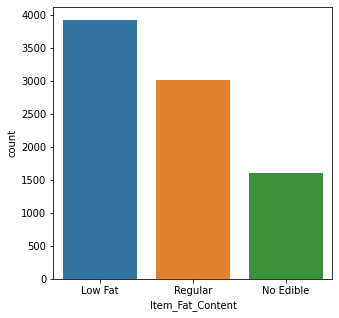

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='Item_Fat_Content', data=df)
plt.show()

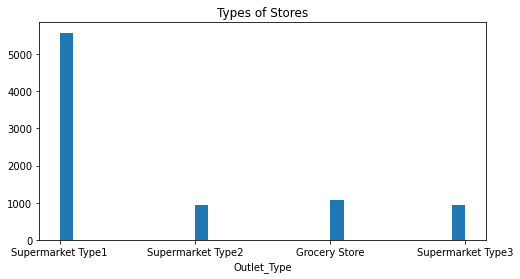

In [ ]:
#Maximum Retail Price Distribution - OOP with ax.set()
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(df['Outlet_Type'],bins=30);
ax.set(xlabel="Outlet_Type", 
       title='Types of Stores');

[Text(0, 0, 'Dairy'),
 Text(0, 0, 'Soft Drinks'),
 Text(0, 0, 'Meat'),
 Text(0, 0, 'Fruits and Vegetables'),
 Text(0, 0, 'Household'),
 Text(0, 0, 'Baking Goods'),
 Text(0, 0, 'Snack Foods'),
 Text(0, 0, 'Frozen Foods'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Health and Hygiene'),
 Text(0, 0, 'Hard Drinks'),
 Text(0, 0, 'Canned'),
 Text(0, 0, 'Breads'),
 Text(0, 0, 'Starchy Foods'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Seafood')]

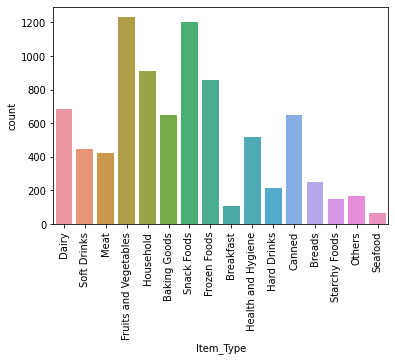

In [ ]:
# displays the various products sold 
labels = list(df['Item_Type'].unique())
chart = sns.countplot(x=df['Item_Type'])
chart.set_xticklabels(labels=labels, rotation=90)

[Text(0, 0, 'OUT049'),
 Text(0, 0, 'OUT018'),
 Text(0, 0, 'OUT010'),
 Text(0, 0, 'OUT013'),
 Text(0, 0, 'OUT027'),
 Text(0, 0, 'OUT045'),
 Text(0, 0, 'OUT017'),
 Text(0, 0, 'OUT046'),
 Text(0, 0, 'OUT035'),
 Text(0, 0, 'OUT019')]

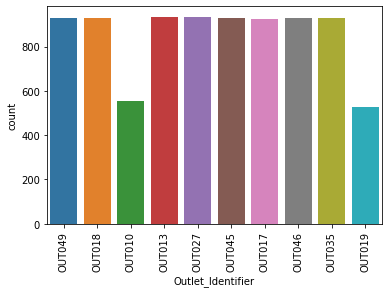

In [ ]:
# plot outlet identifier
labels = list(df['Outlet_Identifier'].unique())
chart = sns.countplot(x=df['Outlet_Identifier'])
chart.set_xticklabels(labels=labels, rotation=90)

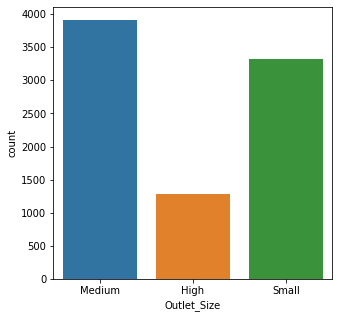

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='Outlet_Size', data=df)
plt.show()

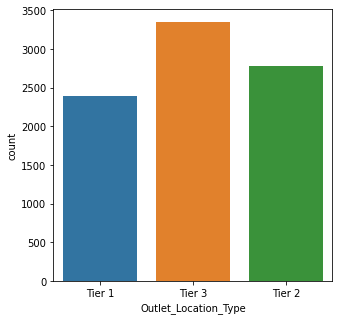

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='Outlet_Location_Type', data=df)
plt.show()

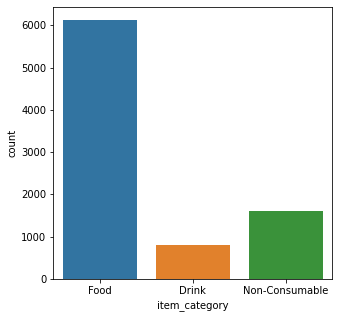

In [ ]:
plt.figure(figsize=(5,5))
sns.countplot(x='item_category', data=df)
plt.show()

### **Plot data distribution**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4940d66400>,
      dtype=object)

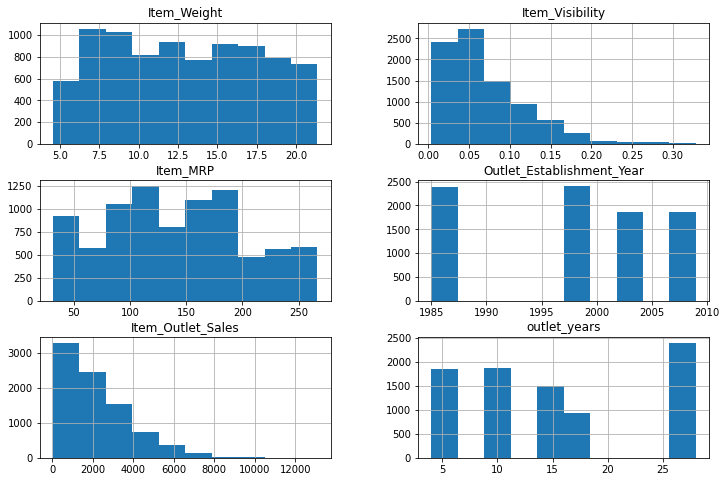

In [ ]:
df.hist(figsize=(12,8))

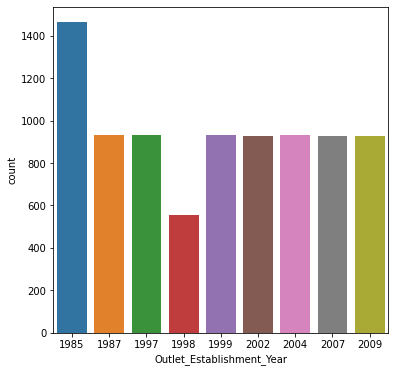

In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=df)
plt.show()

In [ ]:
# correlation with the target column 
corr_matrix = df.corr()
corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
outlet_years                 0.049135
Item_Weight                  0.013116
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.134138
Name: Item_Outlet_Sales, dtype: float64

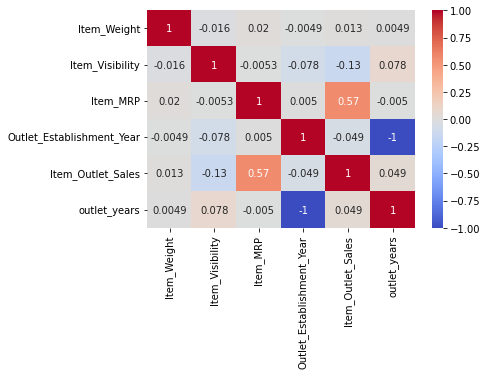

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

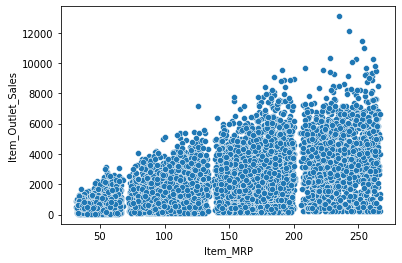

In [ ]:
# scatter plot of item_mrp and item_outlet_sales
sns.scatterplot(data=df, x='Item_MRP',y='Item_Outlet_Sales')

**Notes**:
This isn't a clear correlation between item mrp and item outlet sales. Item_MRP is the most essential feature to estimiate the item outlet sales.

In [190]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,outlet_years
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.849649,0.070213,140.992782,1997.831867,2181.288914,15.168133
std,4.631020,0.048742,62.275067,8.371760,1706.499616,8.371760
min,4.555000,0.003575,31.290000,1985.000000,33.290000,4.000000
25%,8.785000,0.033085,93.826500,1987.000000,834.247400,9.000000
50%,12.600000,0.062517,143.012800,1999.000000,1794.331000,14.000000
75%,16.750000,0.094585,185.643700,2004.000000,3101.296400,26.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,28.000000


## **Data Preprocessing**

In [ ]:
clean_data.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales,item_category,outlet_years
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drink,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,14
3,FDX07,19.20,Regular,0.066132,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800,Food,15
4,NCD19,8.93,No Edible,0.066132,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,26


In [ ]:
# applying label encoding to some features
encoder = LabelEncoder()

cols_to_encode = ['item_identifier','item_type', 'outlet_identifier']

for col in cols_to_encode:
  clean_data[col] = encoder.fit_transform(clean_data[col])

In [ ]:
# applying one hot encoding to some features
clean_data = pd.get_dummies(clean_data, columns=['item_fat_content','outlet_size','outlet_location_type','outlet_type','item_category'])

In [ ]:
clean_data.head()

,item_identifier,item_weight,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,item_outlet_sales,outlet_years,item_fat_content_Low Fat,...,outlet_location_type_Tier 1,outlet_location_type_Tier 2,outlet_location_type_Tier 3,outlet_type_Grocery Store,outlet_type_Supermarket Type1,outlet_type_Supermarket Type2,outlet_type_Supermarket Type3,item_category_Drink,item_category_Food,item_category_Non-Consumable
0,156,9.30,0.016047,4,249.8092,9,1999,3735.1380,14,1,...,1,0,0,0,1,0,0,0,1,0
1,8,5.92,0.019278,14,48.2692,3,2009,443.4228,4,0,...,0,0,1,0,0,1,0,1,0,0
2,662,17.50,0.016760,10,141.6180,9,1999,2097.2700,14,1,...,1,0,0,0,1,0,0,0,1,0
3,1121,19.20,0.066132,6,182.0950,0,1998,732.3800,15,0,...,0,0,1,1,0,0,0,0,1,0
4,1297,8.93,0.066132,9,53.8614,1,1987,994.7052,26,0,...,0,0,1,0,1,0,0,0,0,1


### **Split the Data**

In [ ]:
## Define features (X) and target (y)
#X = df.drop(columns=['Item_Outlet_Sales','Item_Identifier', 'Item_Visibility','Item_Type','Outlet_Size', 'Outlet_Type', 'Item_Fat_Content', 'Outlet_Identifier','Outlet_Establishment_Year'])
#y = df['Item_Outlet_Sales'].copy()

X = clean_data.drop(columns =['outlet_establishment_year','item_outlet_sales','outlet_identifier','item_identifier'])
y = clean_data['item_outlet_sales']

# split the data
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6392 entries, 4776 to 7270
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   item_weight                    6392 non-null   float64
 1   item_visibility                6392 non-null   float64
 2   item_type                      6392 non-null   int64  
 3   item_mrp                       6392 non-null   float64
 4   outlet_years                   6392 non-null   int64  
 5   item_fat_content_Low Fat       6392 non-null   uint8  
 6   item_fat_content_No Edible     6392 non-null   uint8  
 7   item_fat_content_Regular       6392 non-null   uint8  
 8   outlet_size_High               6392 non-null   uint8  
 9   outlet_size_Medium             6392 non-null   uint8  
 10  outlet_size_Small              6392 non-null   uint8  
 11  outlet_location_type_Tier 1    6392 non-null   uint8  
 12  outlet_location_type_Tier 2    6392 non-null 

In [ ]:
# df to store model error and scores
model_scores = pd.DataFrame(columns=['model', 'rmse','r2_score'])



### **ColumnSelector**

In [ ]:
# Instantiate the column seelctors
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')


In [ ]:
cat_selector(X_train)

[]

In [ ]:
train_cat_data = X_train[cat_selector(X_train)]
test_cat_data = X_test[cat_selector(X_test)]


In [ ]:
# instantiate one hot encoder
ohe_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Fit the One hot encoder on the training data
ohe_encoder.fit(train_cat_data)
# transform both the training and testing data
train_ohe = ohe_encoder.transform(train_cat_data)
test_ohe = ohe_encoder.transform(test_cat_data)
train_ohe

array([], shape=(6392, 0), dtype=float64)

In [ ]:
# convert to dataframe, extract new column names from encoder 
ohe_column_names = ohe_encoder.get_feature_names_out(train_cat_data.columns)
train_phe = pd.DataFrame(train_ohe, columns=ohe_column_names)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_column_names)
train_ohe

array([], shape=(6392, 0), dtype=float64)

###**Imputers**

In [ ]:
# Instantiate an imputer and scaler 
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='median')

### **Transformers**

In [ ]:
#scaler
scaler = StandardScaler()
# One hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
#create tuples
num_tuple = (scaler,num_selector)
cat_tuple = (ohe, cat_selector)

###**Column Transformer**

In [ ]:
# instantiate ColumnTransformer
preprocessor = make_column_transformer(num_tuple,cat_tuple,remainder='drop')
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f493e398d60>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f4941ab5190>)])

In [ ]:
# fit ColumnTransformer on the training data
preprocessor.fit(X_train)
# transform both the training and testing data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_processed
                                        

array([[ 1.2086488 ,  0.74726956, -0.8417472 , ..., -0.32096705,
        -1.58984082,  2.06419605],
       [ 0.62727178,  0.50965915, -0.08324982, ..., -0.32096705,
         0.62899379, -0.48445011],
       [-0.32832494, -0.11676829,  1.83719849, ..., -0.32096705,
         0.62899379, -0.48445011],
       ...,
       [ 1.52049855,  1.01728139, -1.06207017, ..., -0.32096705,
        -1.58984082,  2.06419605],
       [-0.38401239,  1.6113074 , -0.32737915, ..., -0.32096705,
         0.62899379, -0.48445011],
       [ 1.40912364,  0.74726956, -1.10252828, ..., -0.32096705,
        -1.58984082,  2.06419605]])

## **Model the Data**

### **Baseline Model**

In [ ]:
# creating an instance of the model
dummy = DummyRegressor(strategy='mean')

# creating a model pipeline
dummy_pipe = make_pipeline(preprocessor, dummy)

# fitting the model
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f493e398d60>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4941ab5190>)])),
                ('dummyregressor', DummyRegressor())])

#### **Metrics**

In [ ]:
# Displaying model performance metrics using a function
model_metrics(dummy_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Dummy Model')



Dummy Model Train Scores
MAE: 1,360.2184 
MSE: 2,959,455.7045 
RMSE: 1,720.3069 
R2: 0.0000

Dummy Model Test Scores
MAE: 1,326.1210 
MSE: 2,772,144.4627 
RMSE: 1,664.9758 
R2: -0.0048



In [187]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,outlet_years
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.849649,0.070213,140.992782,1997.831867,2181.288914,15.168133
std,4.631020,0.048742,62.275067,8.371760,1706.499616,8.371760
min,4.555000,0.003575,31.290000,1985.000000,33.290000,4.000000
25%,8.785000,0.033085,93.826500,1987.000000,834.247400,9.000000
50%,12.600000,0.062517,143.012800,1999.000000,1794.331000,14.000000
75%,16.750000,0.094585,185.643700,2004.000000,3101.296400,26.000000
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,28.000000


###**Linear Regression Model**


In [ ]:
# creating an instance of the model
lin_reg = LinearRegression()

# creating a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)

# fitting the model
lin_reg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4940ec33a0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4940ec3160>)])),
                ('linearregression', LinearRegression())])

In [ ]:
# Create model pipeline
train_pred = lin_reg_pipe.predict(X_train)
test_pred = lin_reg_pipe.predict(X_test)
test_pred[:10]

array([1348.07500924,  784.98125924,  813.07500924, 4231.07500924,
       3275.07500924,  593.07500924, 4752.07500924, 2087.07500924,
       1391.07500924, 2824.98125924])

#### **Metrics**

In [ ]:
# Displaying model performance metrics using a function
model_metrics(lin_reg_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Linear Regression')

Linear Regression Train Scores
MAE: 848.5152 
MSE: 1,302,636.8858 
RMSE: 1,141.3312 
R2: 0.5598

Linear Regression Test Scores
MAE: 803.6604 
MSE: 1,192,130.7291 
RMSE: 1,091.8474 
R2: 0.5679



### **Regression Tree Model**

In [ ]:
# creates the regression tree model
dec_tree = DecisionTreeRegressor(random_state=42) 

## Create a model pipeline
dec_tree_pipe = make_pipeline(preprocessor, dec_tree)

## Fit the model
dec_tree_pipe.fit(X_train, y_train) 


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f493e398d60>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f4941ab5190>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
# predict the target values for the training set and test set
train_preds = dec_tree.predict(X_train)
test_preds = dec_tree.predict(X_test)
train_preds[:10]

array([3527.63588167, 2806.71047245, 2803.01002635, 1344.5831    ,
       2113.62473744,  165.1184    , 1344.5831    , 3401.5722    ,
       3956.56405714, 1832.45421481])

In [ ]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [ ]:
dec_tree.get_depth()

9

In [ ]:
dec_tree.get_n_leaves()

376

In [ ]:
# Let's run the model with our optimized value for max_depth
dec_tree_9 = DecisionTreeRegressor(max_depth = 9, random_state = 42)
dec_tree_9.fit(X_train, y_train)
train_9_score = dec_tree_9.score(X_train, y_train)
test_9_score = dec_tree_9.score(X_test, y_test)
print(train_9_score)
print(test_9_score)

0.659780666459937
0.5396442374450603


In [ ]:
# Displaying model performance metrics using a function
model_metrics(dec_tree_9,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Decision Tree Model')

Decision Tree Model Train Scores
MAE: 688.1017 
MSE: 1,006,864.0474 
RMSE: 1,003.4262 
R2: 0.6598

Decision Tree Model Test Scores
MAE: 783.5367 
MSE: 1,270,111.0932 
RMSE: 1,126.9921 
R2: 0.5396



In [ ]:
# List of values to try for max_depth:
depths = list(range(2, 10)) # Will input every value between 2 and 28
# Data frame to store the score for each value of max_depth:
scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train, y_train)
    train_score = dec_tree.score(X_train, y_train)
    test_score = dec_tree.score(X_test, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


Text(0, 0.5, 'R2')

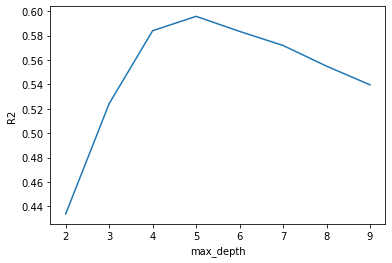

In [ ]:
import matplotlib.pyplot as plt
plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2')

In [ ]:
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head(8)

,Test Score,Train Score
5,0.595784,0.604211
4,0.58399,0.582633
6,0.583442,0.61522
7,0.571902,0.628854
8,0.55496,0.641576
9,0.539644,0.659781
3,0.524222,0.524218
2,0.433778,0.431641


In [188]:
# Let's run the model with our optimized value for max_depth
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train, y_train)
train_5_score = dec_tree_5.score(X_train, y_train)
test_5_score = dec_tree_5.score(X_test, y_test)
print(train_5_score)
print(test_5_score)


0.6042112047143855
0.5957835867721404


#### **Metrics**

In [189]:
## Display model performance metrics for decision tree
model_metrics(dec_tree_5, x_train=X_train, y_train=y_train,
              x_test=X_test, y_test=y_test,
              model_name = "Decision Tree Model")

Decision Tree Model Train Scores
MAE: 762.0948 
MSE: 1,171,319.4080 
RMSE: 1,082.2751 
R2: 0.6042

Decision Tree Model Test Scores
MAE: 738.0686 
MSE: 1,115,223.9035 
RMSE: 1,056.0416 
R2: 0.5958



In [ ]:
# Displaying model performance metrics for the linear regression model again
model_metrics(lin_reg_pipe,x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test,
                          model_name='Linear Regression')

Linear Regression Train Scores
MAE: 848.5152 
MSE: 1,302,636.8858 
RMSE: 1,141.3312 
R2: 0.5598

Linear Regression Test Scores
MAE: 803.6604 
MSE: 1,192,130.7291 
RMSE: 1,091.8474 
R2: 0.5679



## **Recommendation**

Because we need other properties of products and outlets to play crucial roles to predict sales, I will be using the Decision Tree model.  Also, the R2 score is higher. The decision tree has high variance, which could be easier to understand.  
